In [2]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [3]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 9714358

- also known as TIC 270618498

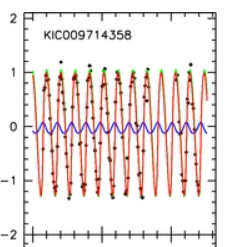

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [7]:
# define the plotting parameters

figsize = (8,4)

In [5]:
# import the data

# choose a TIC ID to analyze
ticid =  270618498  
kicid = 9714358  # ETV amplitude ~2000sec / 33min
# reference: https://www.mdpi.com/2075-4434/10/1/9
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



sr = lk.search_lightcurve('KIC{}'.format(kicid))
sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
sr = lke._sort_chronologically(sr)
display(sr)
lcc_kplr = sr.download_all()
lc_kplr = lcc_kplr[:].stitch()
lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
lc_kplr = lc_kplr.truncate(None, 55300)  # test with ~1 ETV cycle based on reference plot, # 553900 ~2ETV cycles

# sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
# sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (sector 5)
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
# sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
# display(sr)
# lc_tess = sr.download_all().stitch()
# lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    lc_kplr,
    # lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,Kepler Quarter 01,2009,Kepler,1800,kplr009714358,0.0,EX
1,Kepler Quarter 02,2009,Kepler,1800,kplr009714358,0.0,EX
2,Kepler Quarter 03,2009,Kepler,1800,kplr009714358,0.0,EX
3,Kepler Quarter 04,2010,Kepler,1800,kplr009714358,0.0,EX
4,Kepler Quarter 05,2010,Kepler,1800,kplr009714358,0.0,EX
5,Kepler Quarter 06,2010,Kepler,1800,kplr009714358,0.0,EX
6,Kepler Quarter 07,2010,Kepler,1800,kplr009714358,0.0,EX
7,Kepler Quarter 08,2011,Kepler,1800,kplr009714358,0.0,EX
8,Kepler Quarter 09,2011,Kepler,1800,kplr009714358,0.0,EX


15118

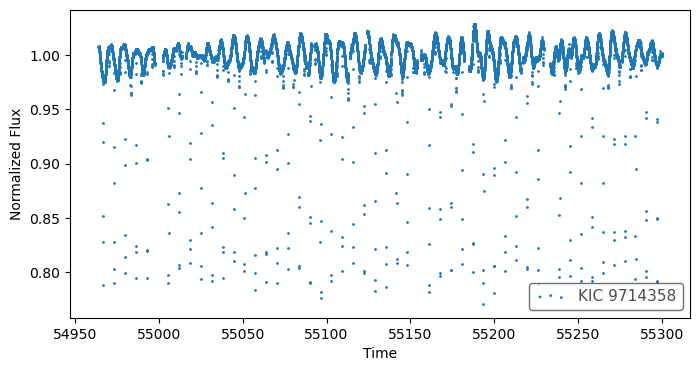

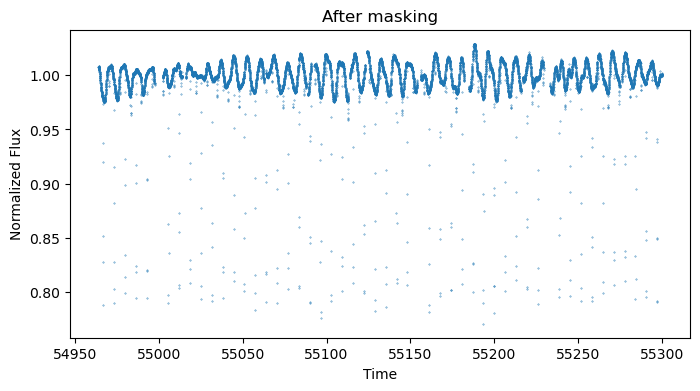

In [8]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

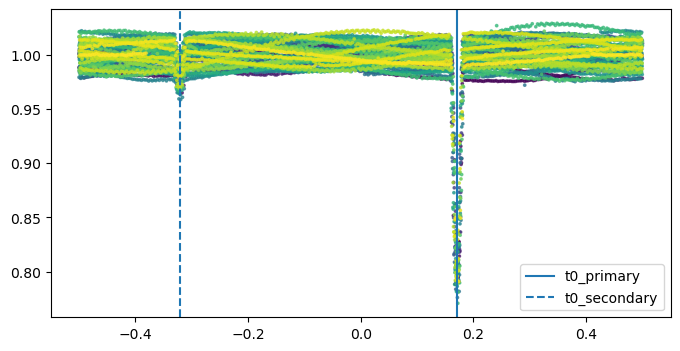

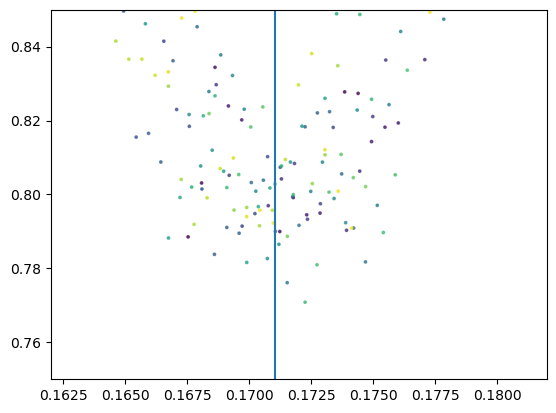

In [19]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
period = 6.47418  # 2013ApJ Period



t0_primary = 54967.395501 - 0.5  # Kepler EB, the MJD there seems to be off by 0.5
t0_secondary = t0_primary + period * 0.5083


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.0185 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 0.0219 * period * 24  

t0_for_plotting = 0  # keep 0 for plotting purposes
# t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.25  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(0.162, 0.182);
plt.ylim(0.75, 0.85);
plt.show()

### Now that the data is ready we can start 

In [20]:
# show data to visualize what's changed in each step below
data  

,time,flux,err,phase
0,54964.012068,1.007934,0.000314,-0.274341
1,54964.032502,1.007933,0.000314,-0.271185
2,54964.052937,1.008144,0.000314,-0.268028
3,54964.073371,1.008299,0.000314,-0.264872
4,54964.093806,1.007637,0.000314,-0.261716
...,...,...,...,...
15090,55299.898238,1.000963,0.000319,-0.393459
15091,55299.918672,1.001149,0.000319,-0.390302
15092,55299.939107,1.000448,0.000319,-0.387146
15093,55299.959541,1.001066,0.000319,-0.383990


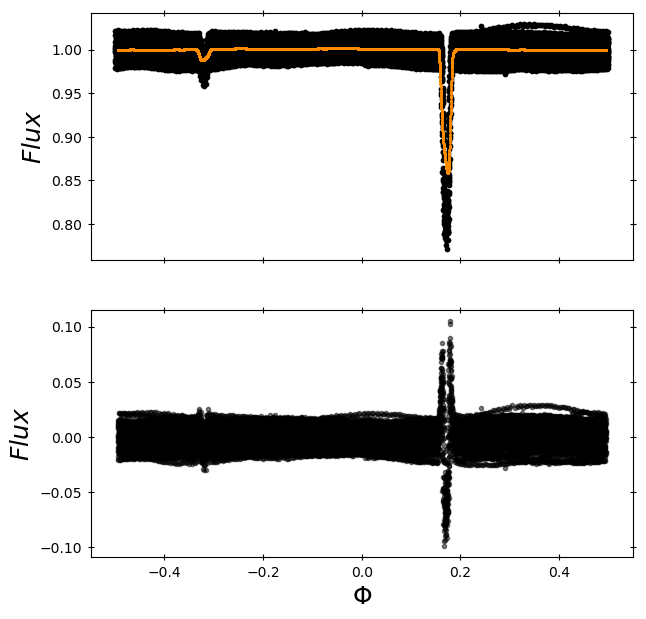

,time,flux,err,phase,flux_sub_binary,binary_model
0,54964.012068,1.007934,0.000314,-0.274341,0.007144,1.000790
1,54964.032502,1.007933,0.000314,-0.271185,0.007259,1.000674
2,54964.052937,1.008144,0.000314,-0.268028,0.007638,1.000505
3,54964.073371,1.008299,0.000314,-0.264872,0.007875,1.000424
4,54964.093806,1.007637,0.000314,-0.261716,0.006980,1.000657
...,...,...,...,...,...,...
15090,55299.898238,1.000963,0.000319,-0.393459,0.001028,0.999935
15091,55299.918672,1.001149,0.000319,-0.390302,0.001183,0.999966
15092,55299.939107,1.000448,0.000319,-0.387146,0.000434,1.000014
15093,55299.959541,1.001066,0.000319,-0.383990,0.001000,1.000065


In [21]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 14946 901
reached the end
10 14688 901
reached the end
10 14684 901
reached the end
10 14684 901
reached the end


,time,flux,err,phase,flux_sub_binary,binary_model,flux_detrended
0,54964.012068,1.007934,0.000314,-0.274341,0.007144,1.000790,1.001054
1,54964.032502,1.007933,0.000314,-0.271185,0.007259,1.000674,1.001059
2,54964.052937,1.008144,0.000314,-0.268028,0.007638,1.000505,1.001277
3,54964.073371,1.008299,0.000314,-0.264872,0.007875,1.000424,1.001440
4,54964.093806,1.007637,0.000314,-0.261716,0.006980,1.000657,1.000785
...,...,...,...,...,...,...,...
15090,55299.898238,1.000963,0.000319,-0.393459,0.001028,0.999935,1.000028
15091,55299.918672,1.001149,0.000319,-0.390302,0.001183,0.999966,1.000202
15092,55299.939107,1.000448,0.000319,-0.387146,0.000434,1.000014,0.999491
15093,55299.959541,1.001066,0.000319,-0.383990,0.001000,1.000065,1.000097


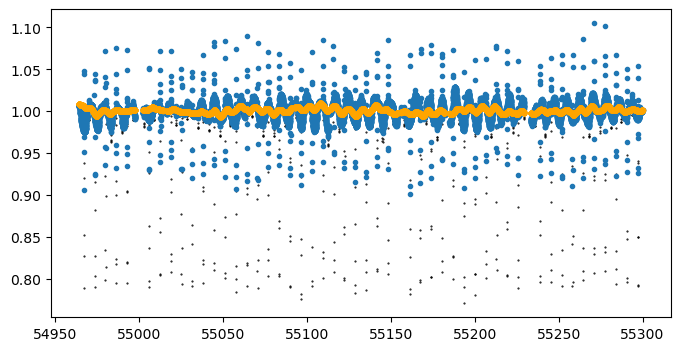

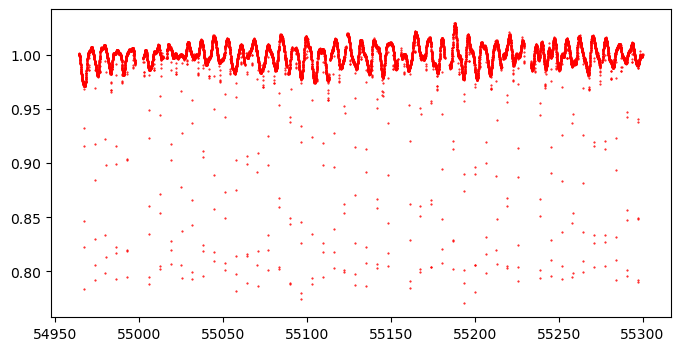

In [22]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

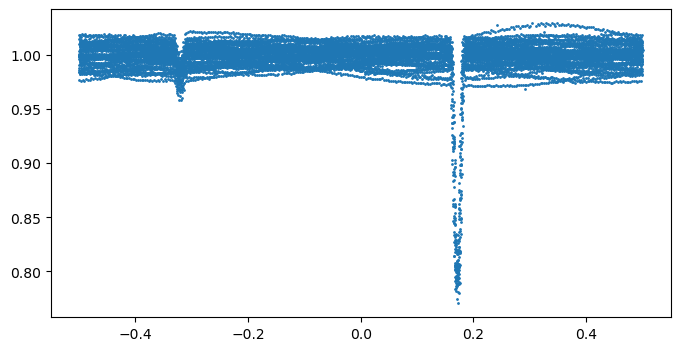

In [23]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   54966.895501 0.1710333972796686
window_width_p (phase): 0.02035
Secondary: 54970.186326694 -0.3206666027204754
window_width_s (phase): 0.02035


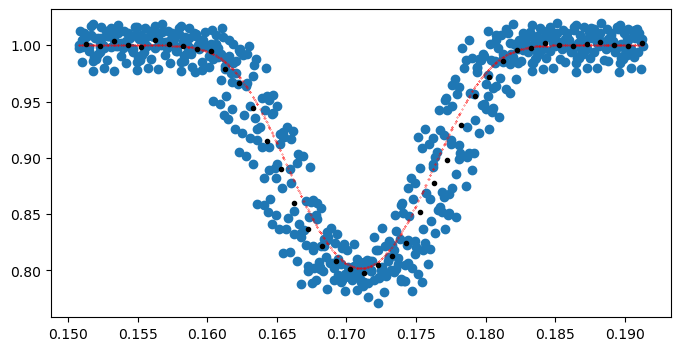

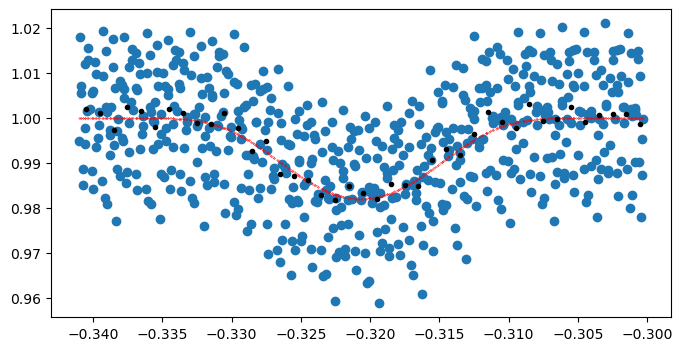

In [35]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.1 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    # window_width_s = 0.9 * duration_hr_secondary / 24 / period
    window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.198, midpoint_p, 0.005, 1.0]
start_vals_s = [1, -0.018, midpoint_s, 0.0055, 1.017]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.98it/s]


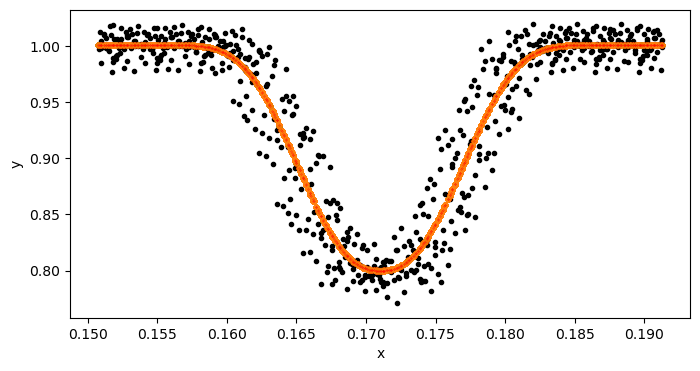

100%|██████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.85it/s]


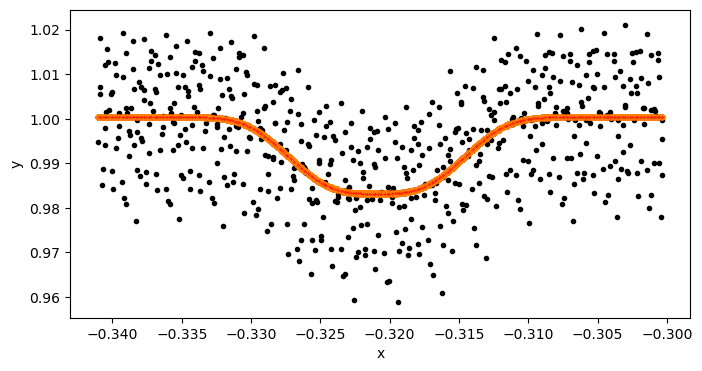

In [36]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [37]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed

    # initial fit params from Kepler data (<MJD 55300) + 2013Apj Period
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.001147590433053, -0.20114767479490359, 0.17102707192074063, 0.005124700986519698, 1.2042815989374624
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0003898377968548, -0.017223173189843427, -0.32095517717339916, 0.004725213244550472, 1.684847812076929

    print("Use pre-defined inital model params:")
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.001147590433053, -0.20114767479490359, 0.17102707192074063, 0.005124700986519698, 1.2042815989374624
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0003898377968548, -0.017223173189843427, -0.32095517717339916, 0.004725213244550472, 1.684847812076929
        etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [38]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.001147590433053, -0.20114767479490359, 0.17102707192074063, 0.005124700986519698, 1.2042815989374624
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0003898377968548, -0.017223173189843427, -0.32095517717339916, 0.004725213244550472, 1.684847812076929


51

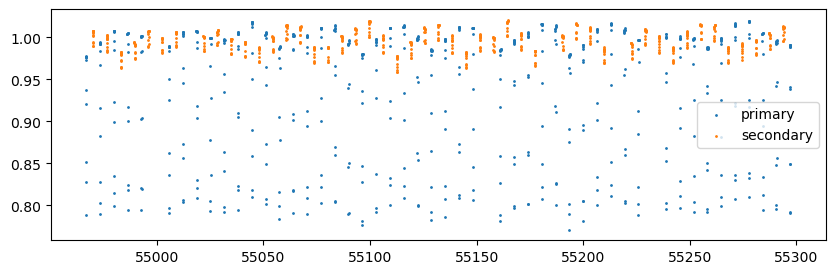

In [39]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

54966.895501 6.47418 54966.895501


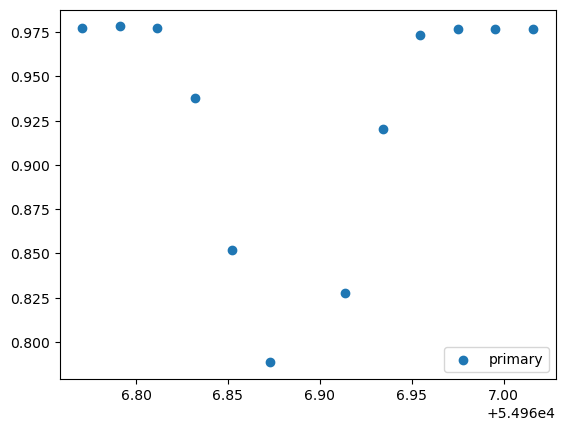

54966.895501 6.47418 54973.369681


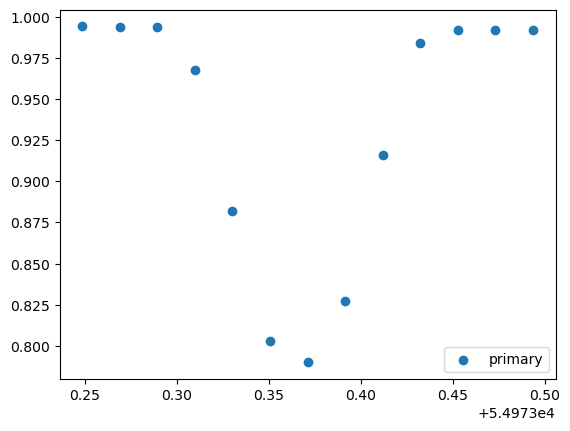

54966.895501 6.47418 54979.843861


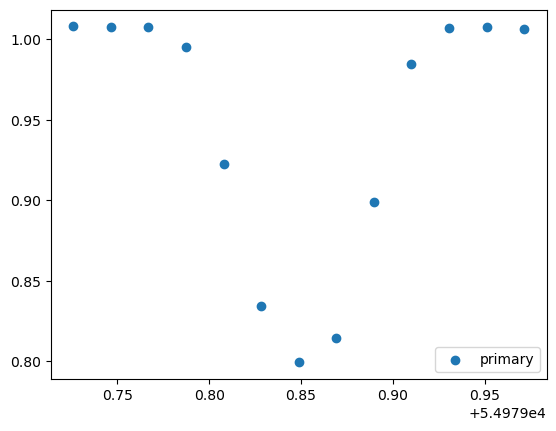

54970.186326694 6.47418 54970.186326694


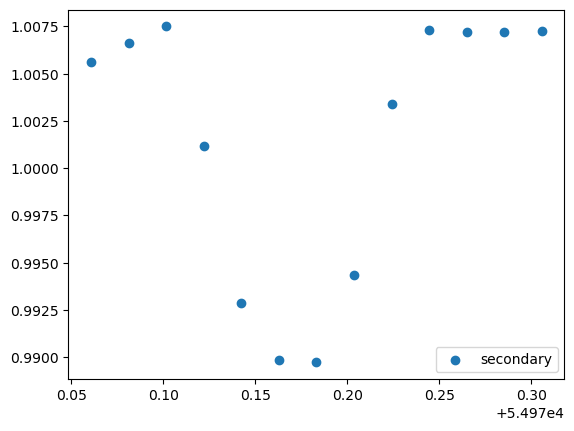

54970.186326694 6.47418 54976.660506693996


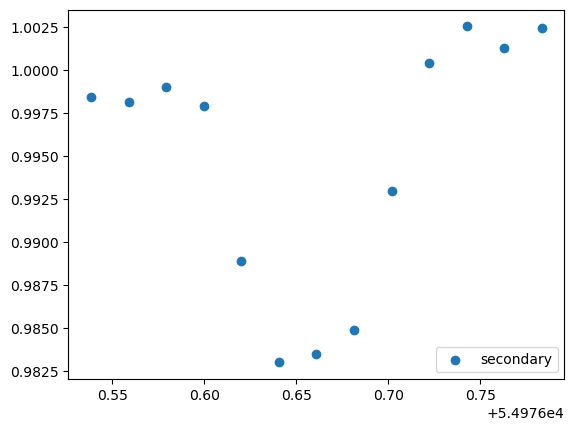

54970.186326694 6.47418 54983.134686694


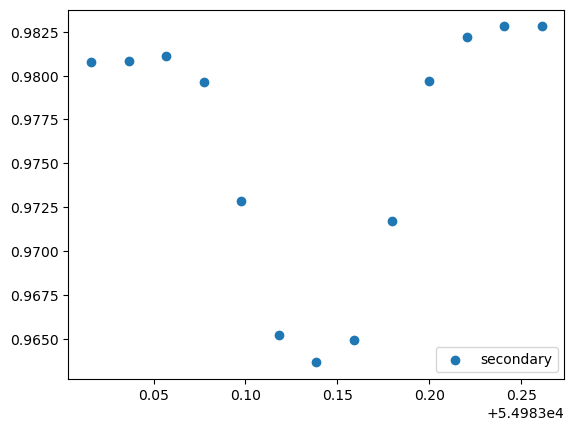

In [40]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Creating new manifest file
54973.369681 1.001147590433053 -0.20114767479490359 0.17102707192074063


  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.70it/s]


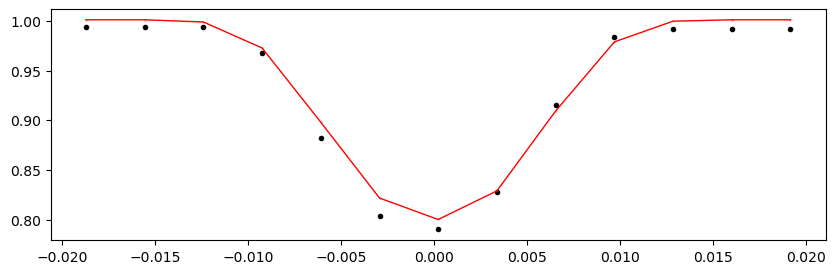

54979.843861 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.50it/s]


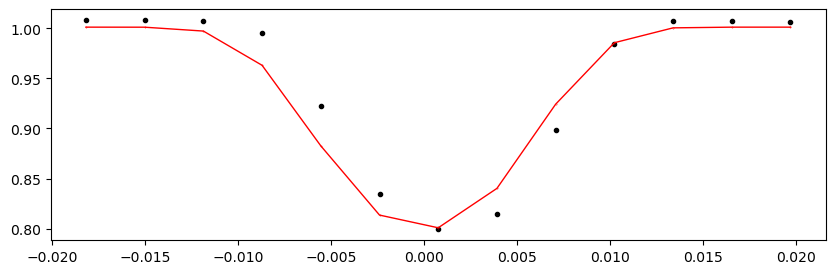

54986.318041 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.78it/s]


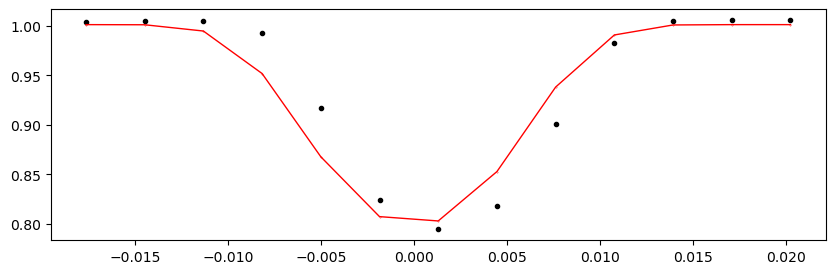

54992.792220999996 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1361.32it/s]


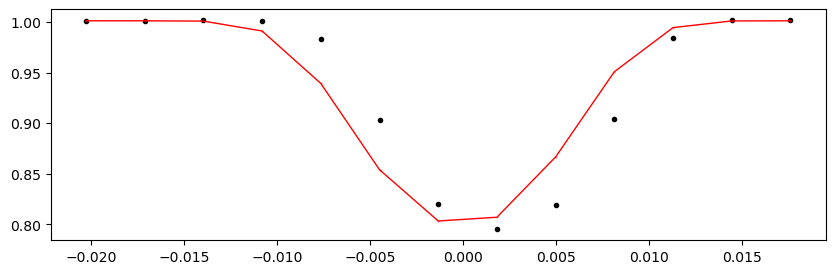

55012.214760999996 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.96it/s]


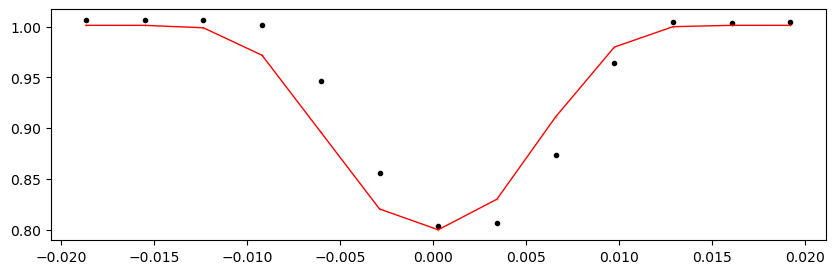

55018.688941 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.83it/s]


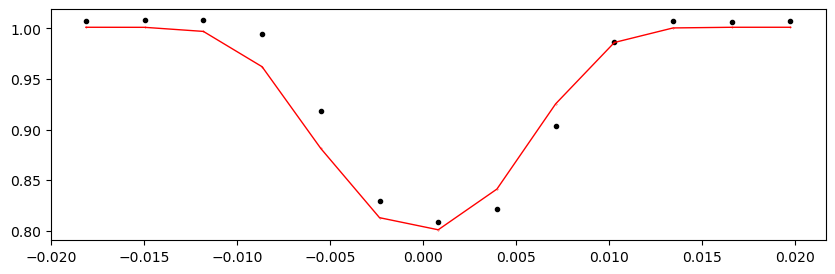

55025.163121 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.30it/s]


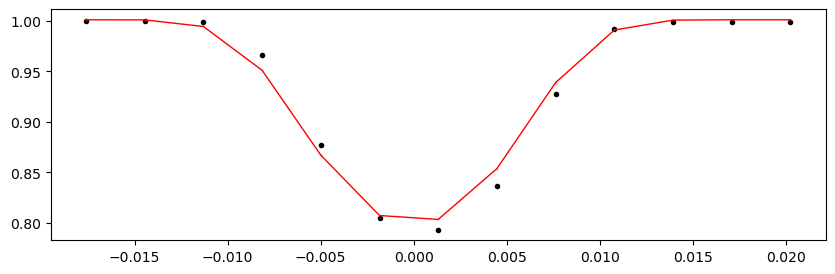

55031.637301 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.78it/s]


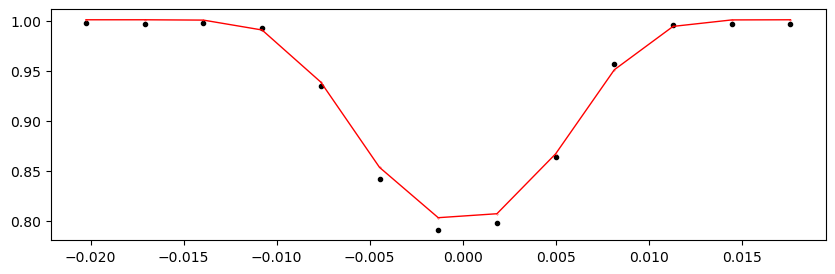

55038.111481 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.36it/s]


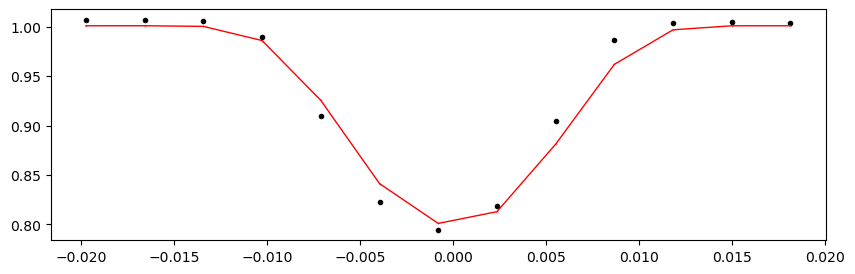

55044.585661 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.49it/s]


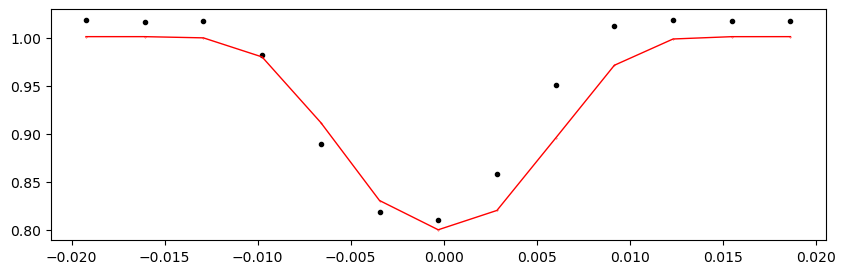

55051.059841 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.17it/s]


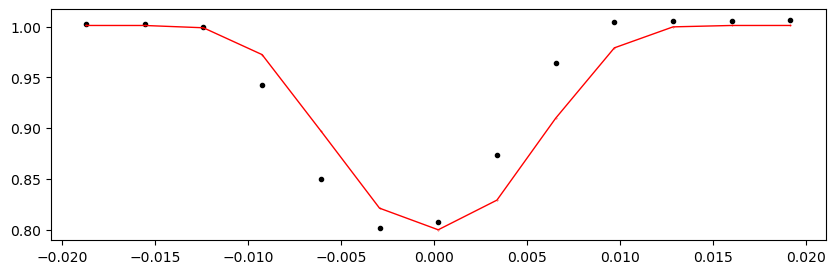

55057.534021 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1312.88it/s]


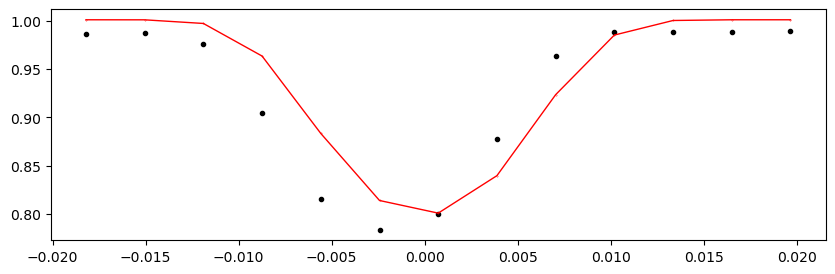

55064.008201 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1254.04it/s]


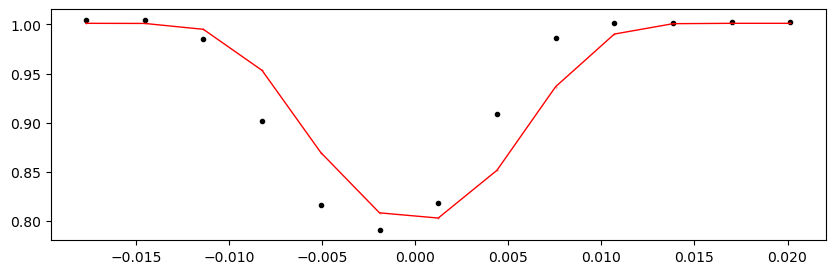

55076.956561 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.40it/s]


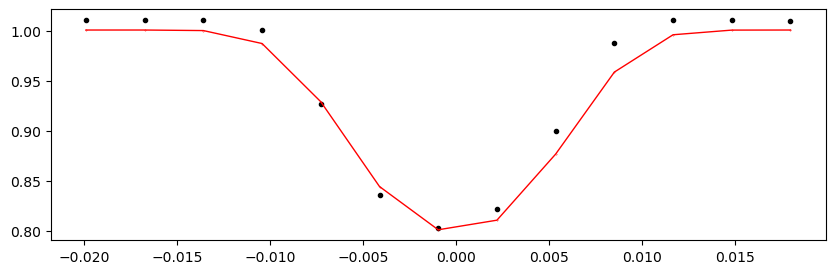

55083.430741 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1325.76it/s]


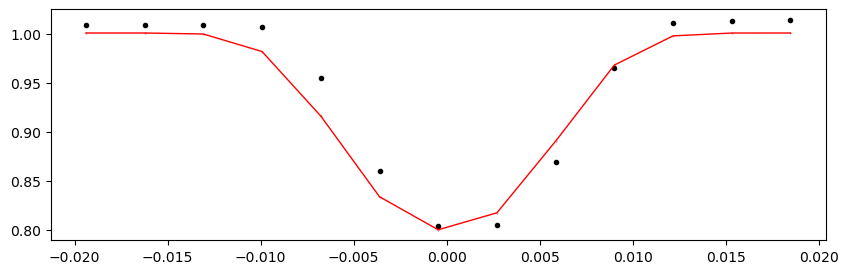

55089.904921 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.99it/s]


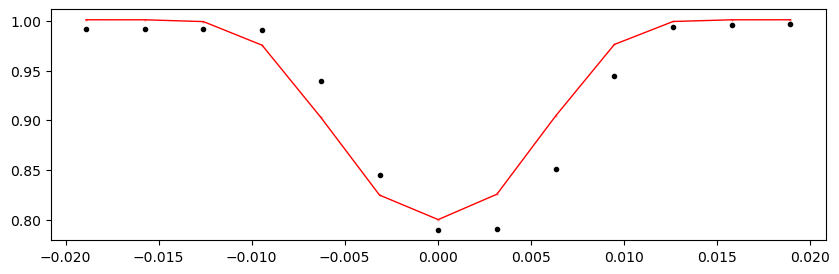

55096.379101 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.78it/s]


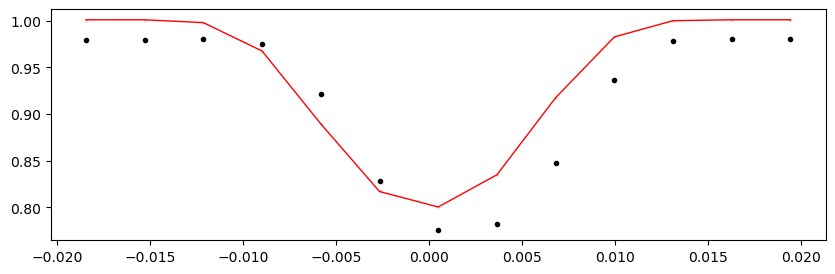

55115.801641 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.91it/s]


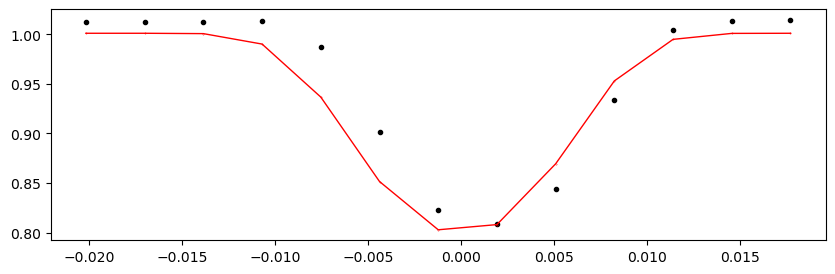

55122.275820999996 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.88it/s]


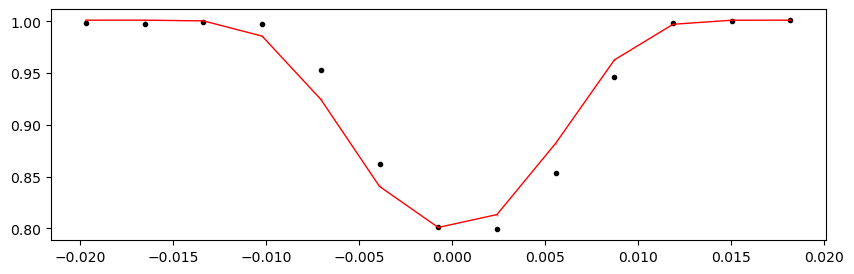

55128.750001 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.95it/s]


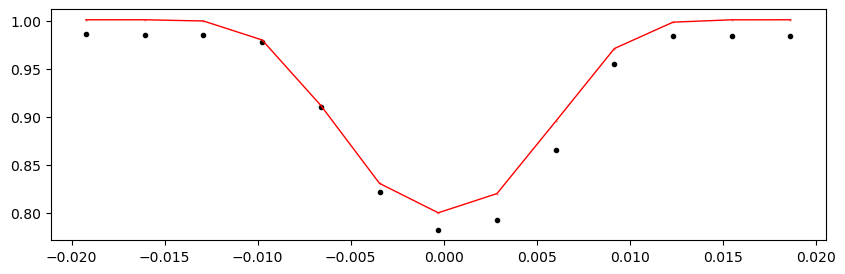

55135.224181 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1265.96it/s]


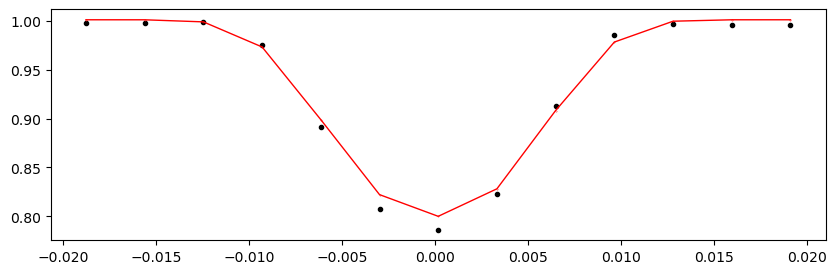

55141.698361 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.37it/s]


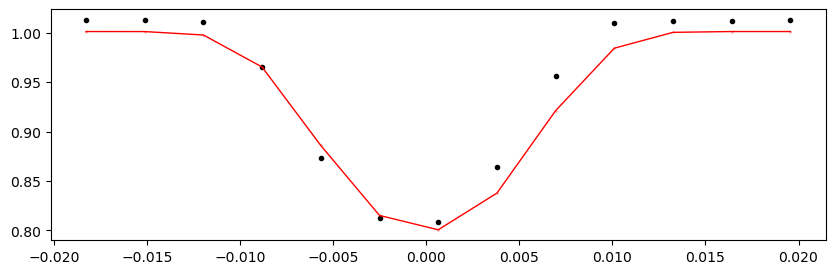

55148.172541 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.48it/s]


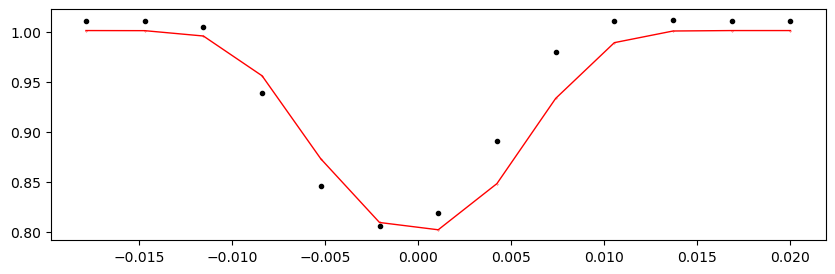

55161.120901 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.12it/s]


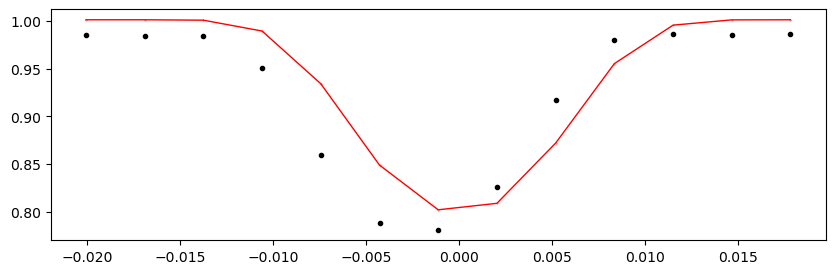

55167.595081 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.92it/s]


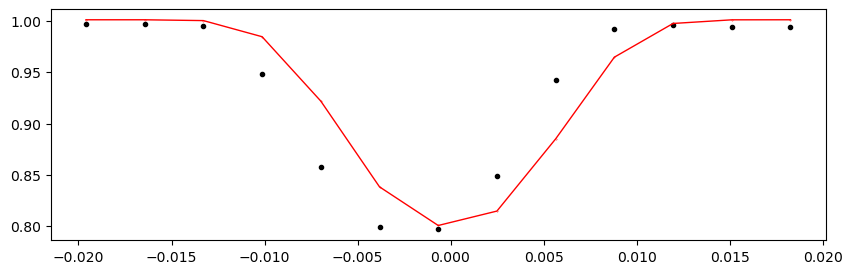

55174.069261 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1321.65it/s]


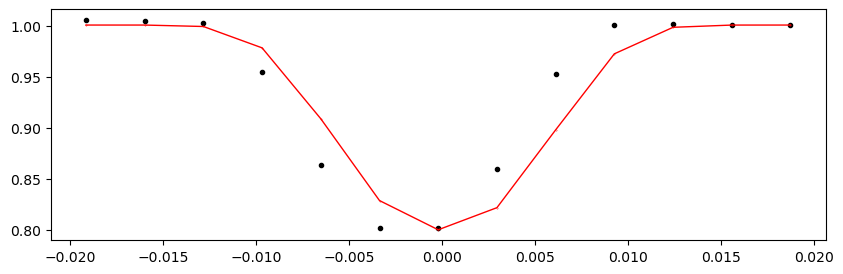

55180.543441 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.51it/s]


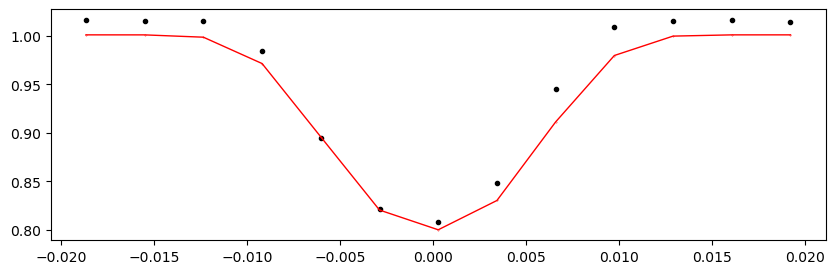

55187.017621 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.05it/s]


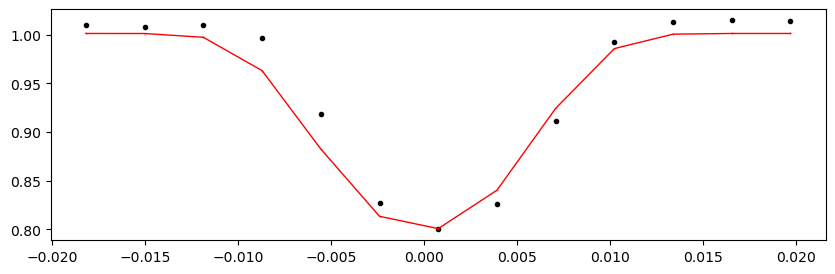

55193.491801 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1322.56it/s]


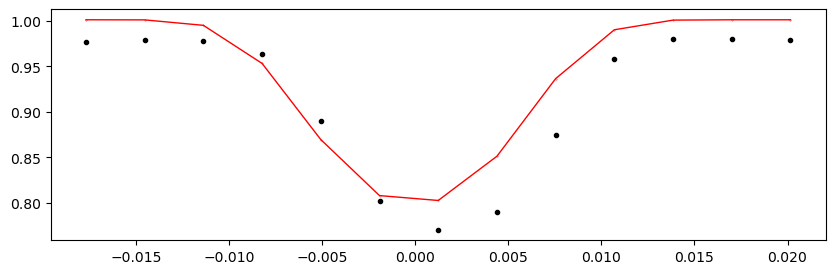

55212.914340999996 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.44it/s]


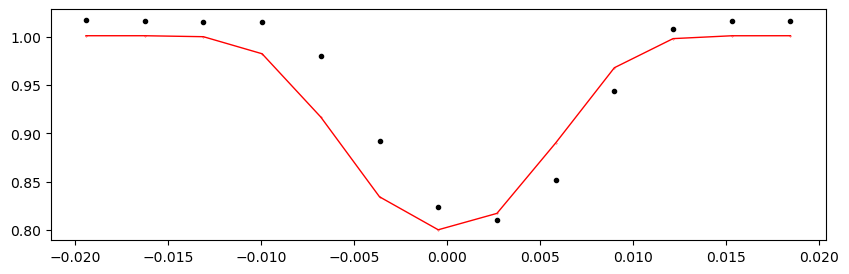

55219.388521 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1310.09it/s]


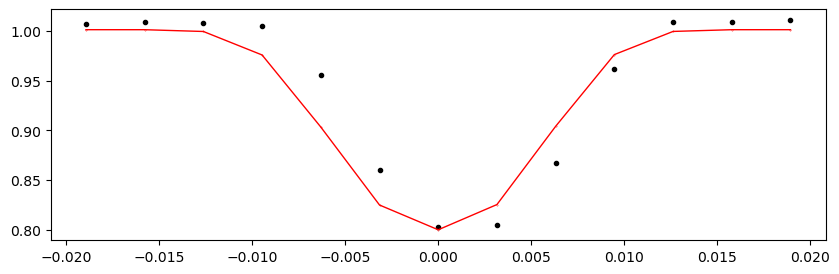

55245.285241 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.30it/s]


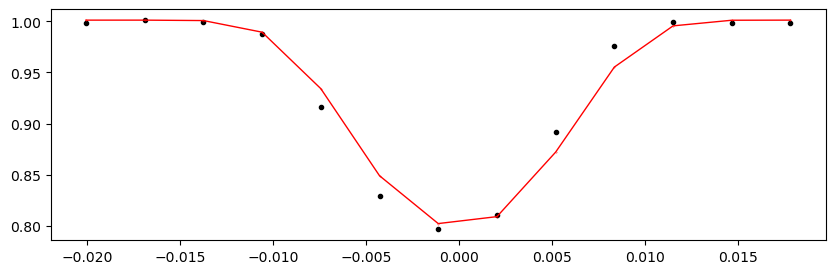

55251.759421 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1357.40it/s]


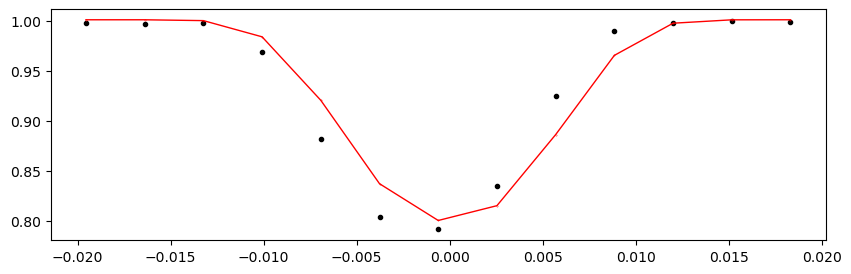

55258.233601 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1360.16it/s]


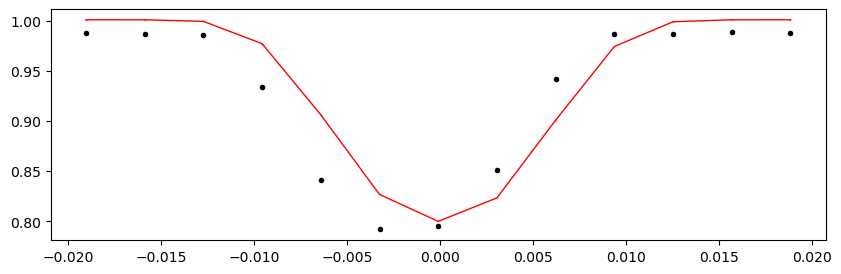

55264.707781 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.54it/s]


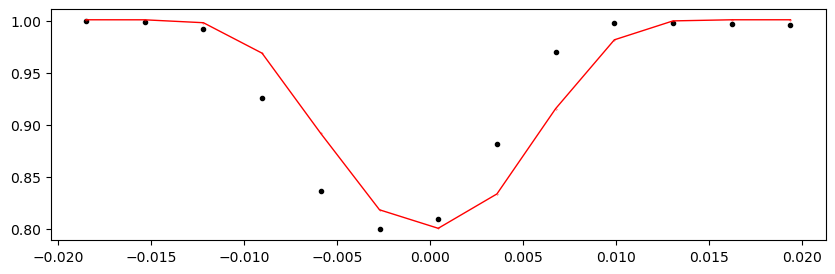

55271.181961 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1356.17it/s]


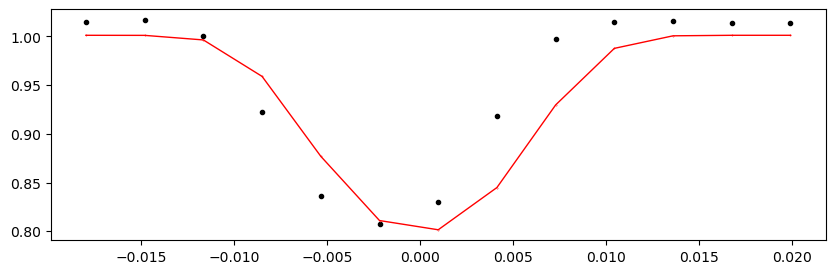

55284.130321 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1363.38it/s]


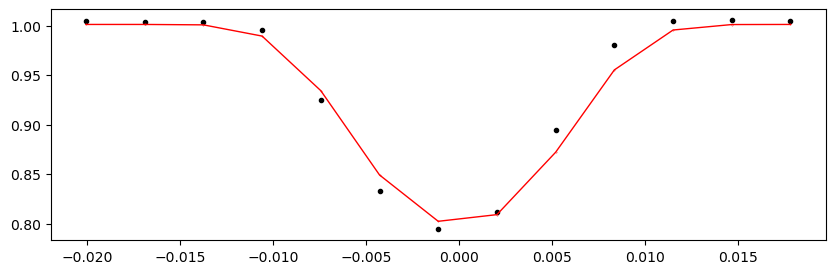

55290.604501 1.001147590433053 -0.20114767479490359 0.17102707192074063


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.54it/s]


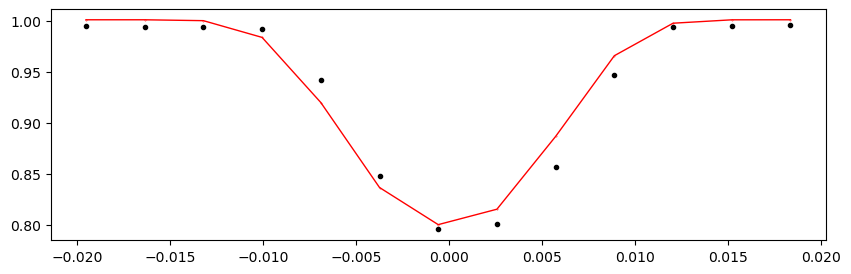

In [41]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

Fitting individual secondary eclipses...
Creating new manifest file
54970.186326694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.75it/s]


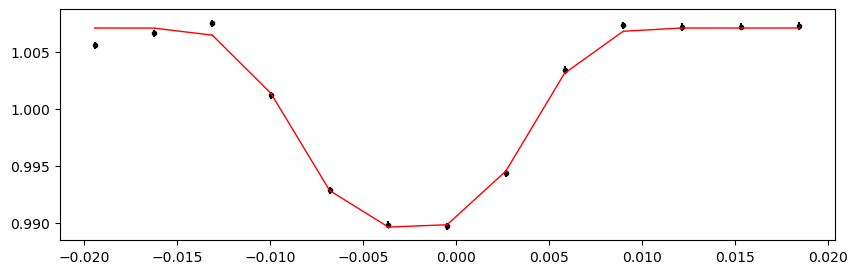

54976.660506693996 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.36it/s]


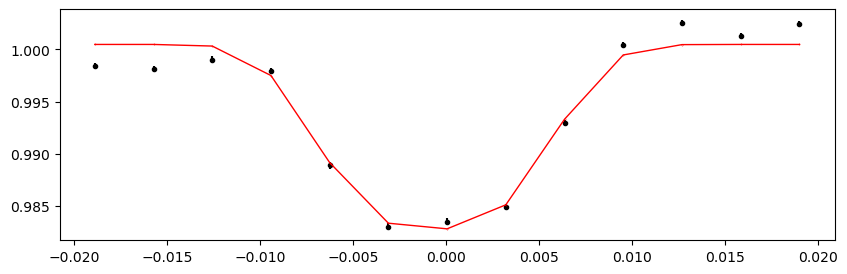

54983.134686694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.08it/s]


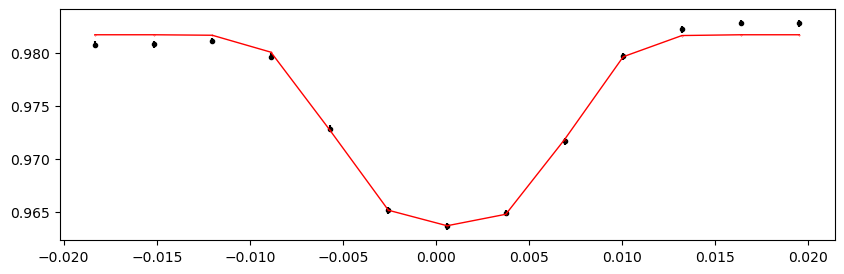

54989.608866694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.12it/s]


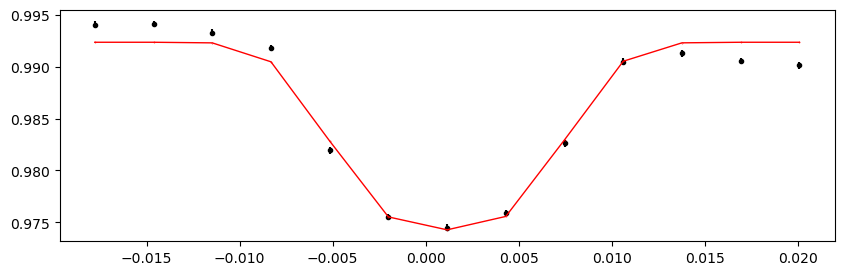

55009.031406694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.05it/s]


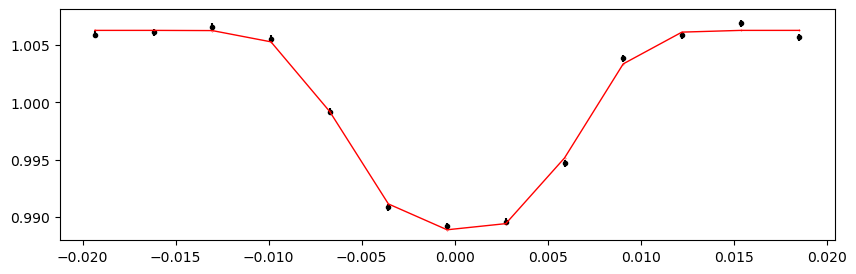

55021.979766694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.67it/s]


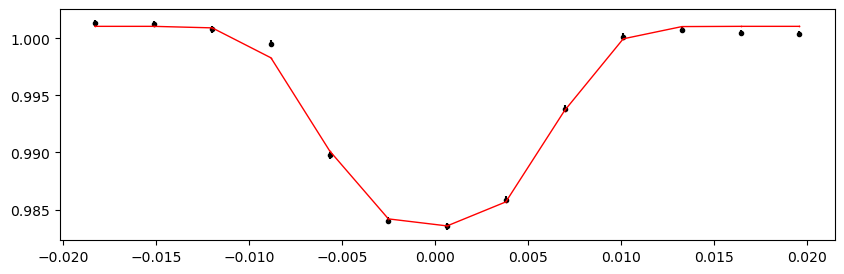

55028.453946694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.71it/s]


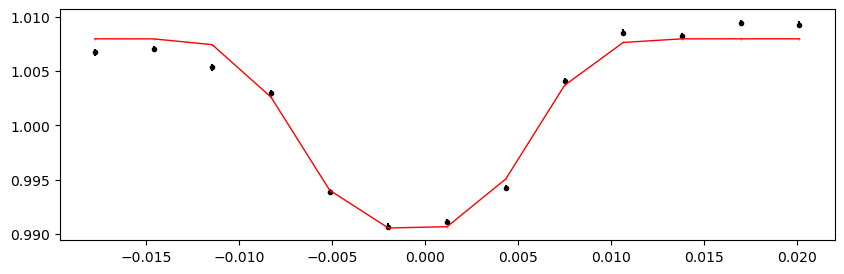

55047.876486694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.15it/s]


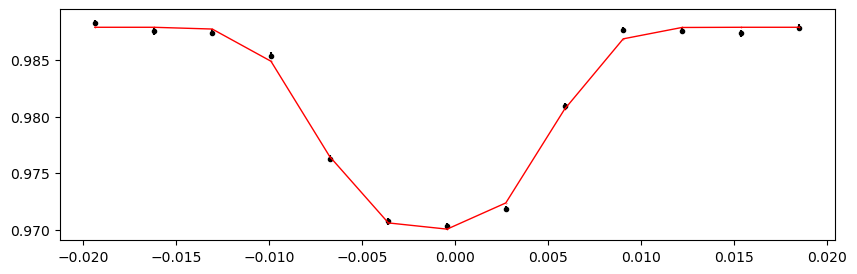

55054.350666694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.03it/s]


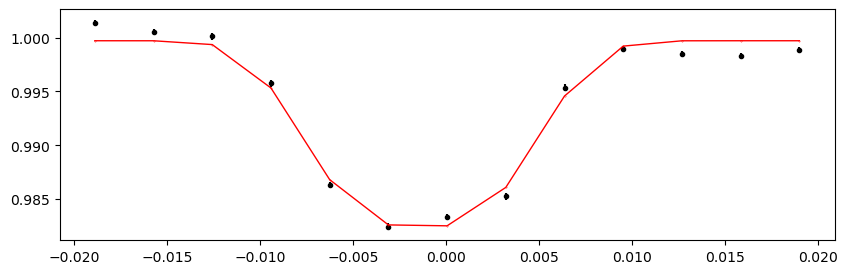

55060.824846694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.12it/s]


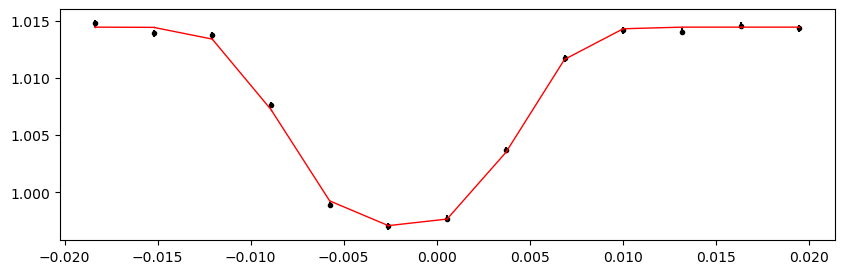

55067.299026693996 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 454.63it/s]


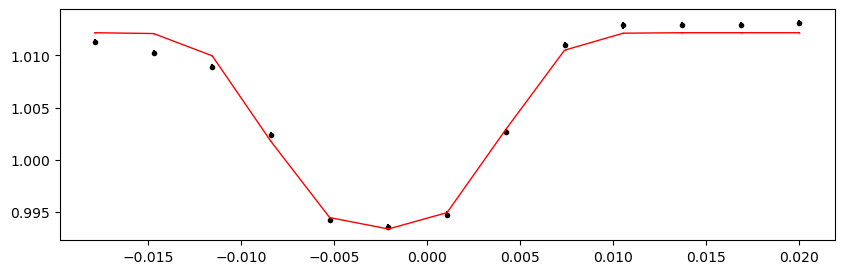

55086.721566693996 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.49it/s]


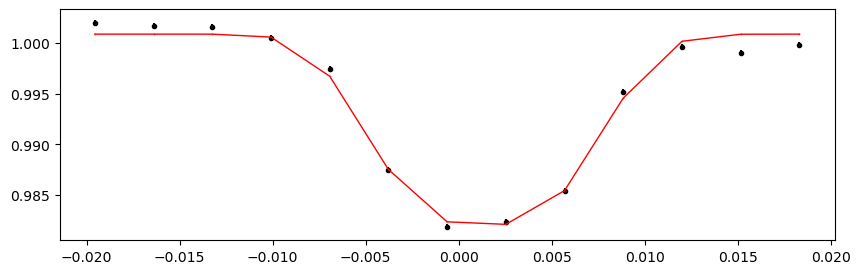

55093.195746694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.74it/s]


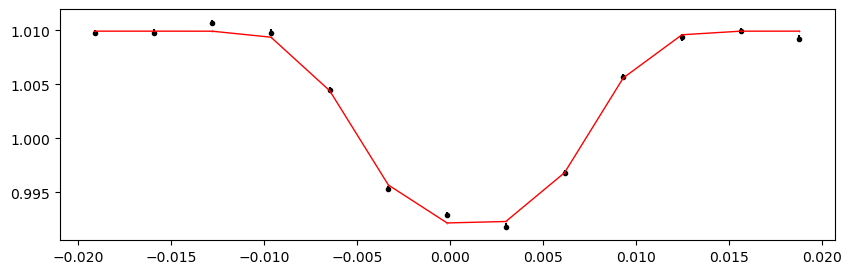

55099.669926694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.43it/s]


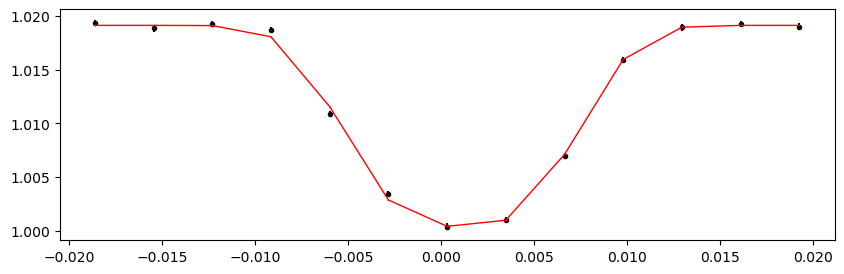

55106.144106693995 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.35it/s]


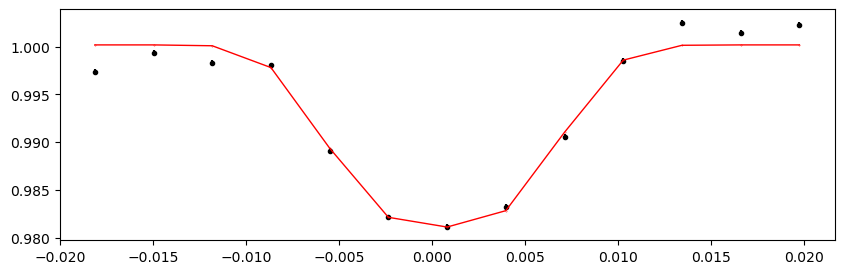

55112.618286694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.12it/s]


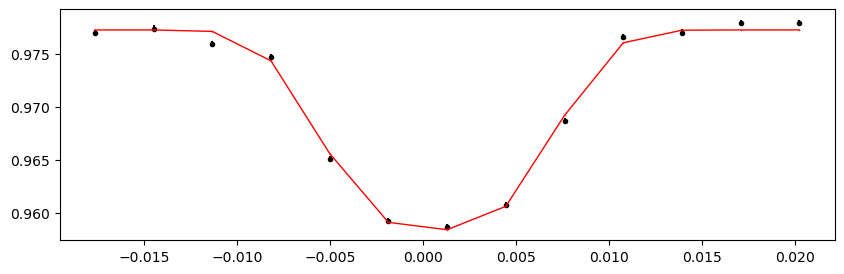

55119.092466694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.66it/s]


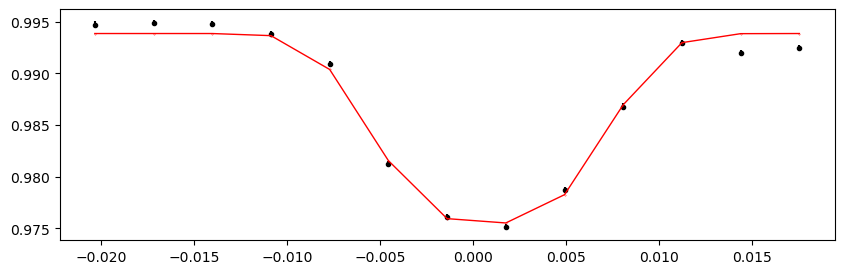

55125.566646693995 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.77it/s]


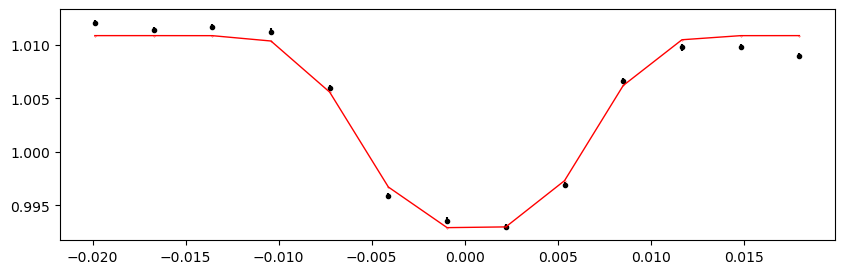

55138.515006694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.52it/s]


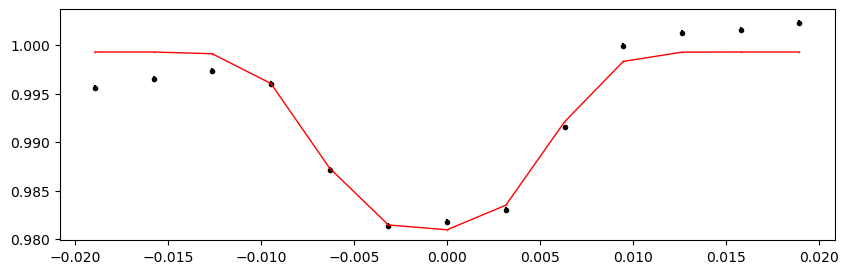

55144.989186694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 480.06it/s]


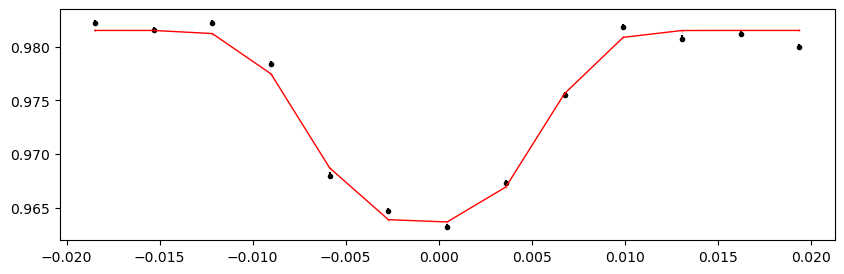

55151.463366694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.85it/s]


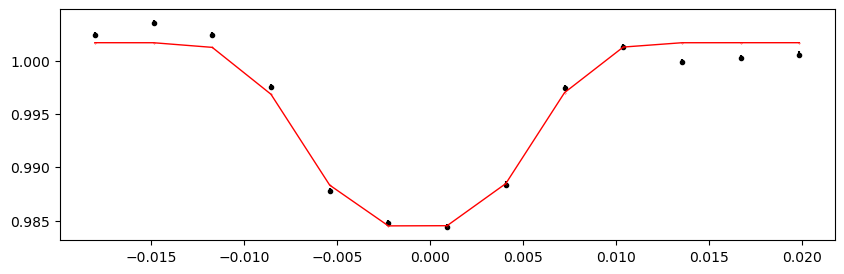

55157.937546694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.20it/s]


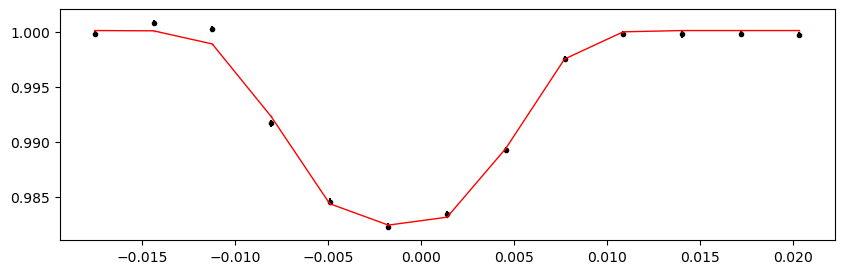

55164.411726694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 490.31it/s]


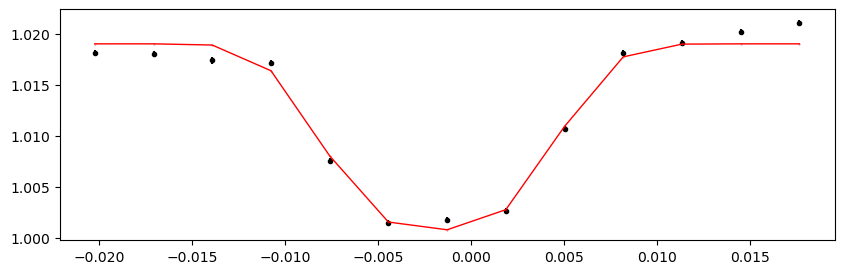

55170.885906694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.87it/s]


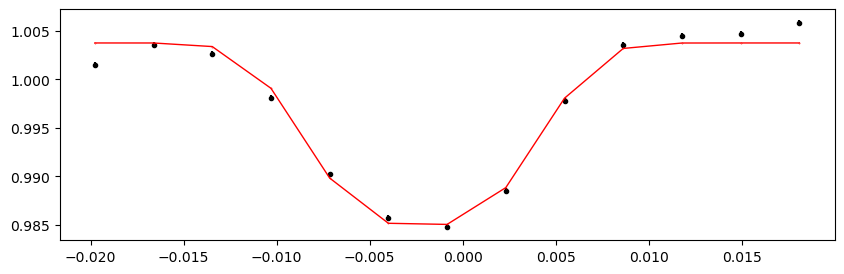

55177.360086693996 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.76it/s]


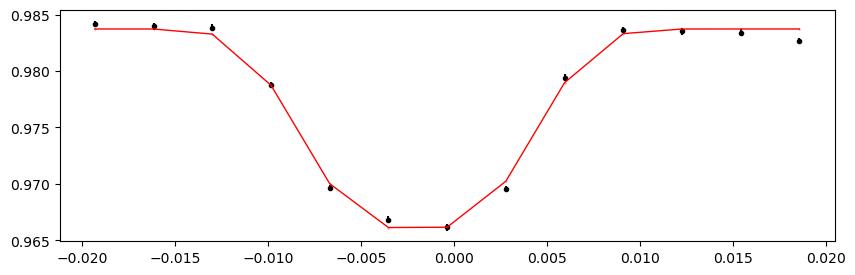

55190.308446694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.48it/s]


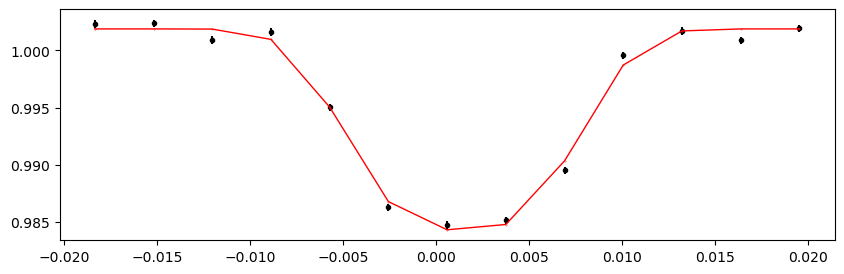

55209.730986694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.32it/s]


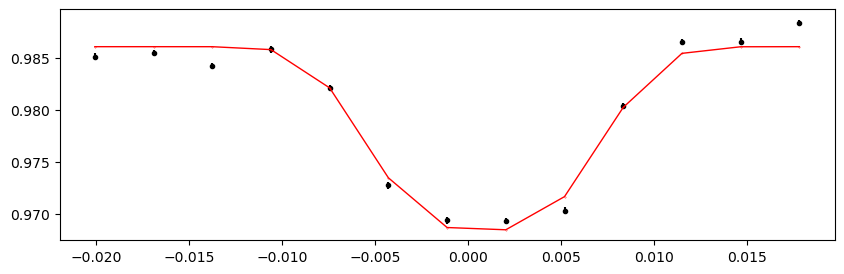

55222.679346694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.33it/s]


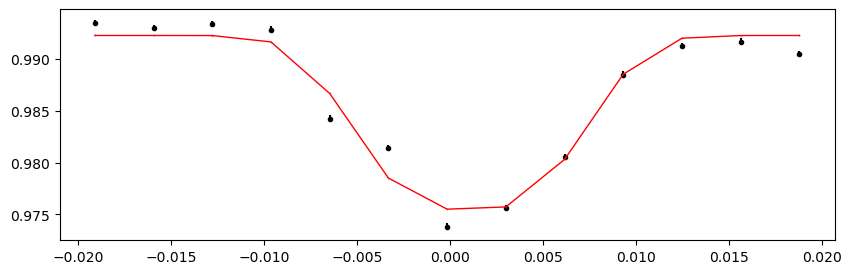

55229.153526694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.88it/s]


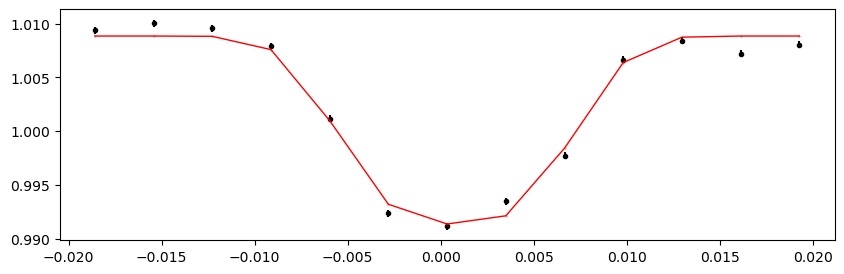

55235.627706693995 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.55it/s]


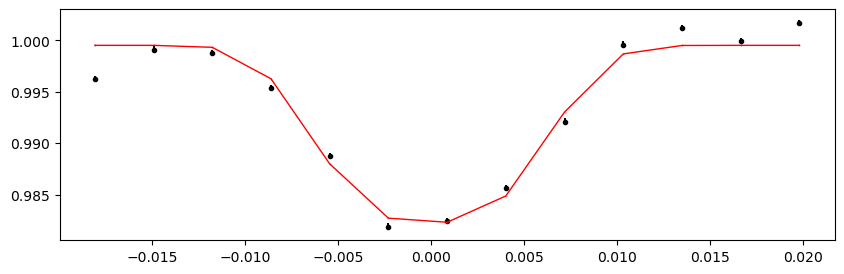

55242.101886694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.24it/s]


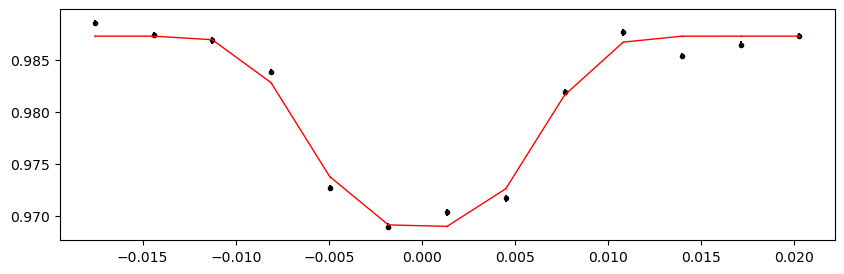

55248.576066694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.91it/s]


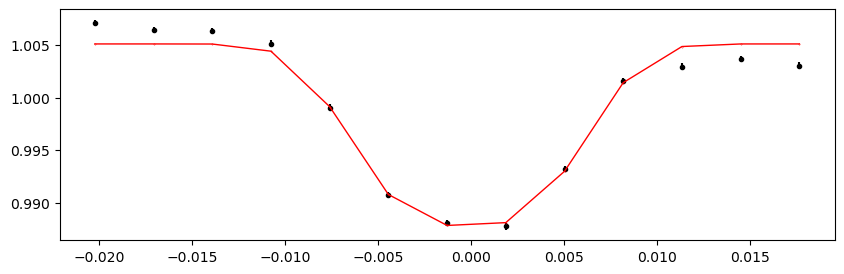

55255.050246694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.89it/s]


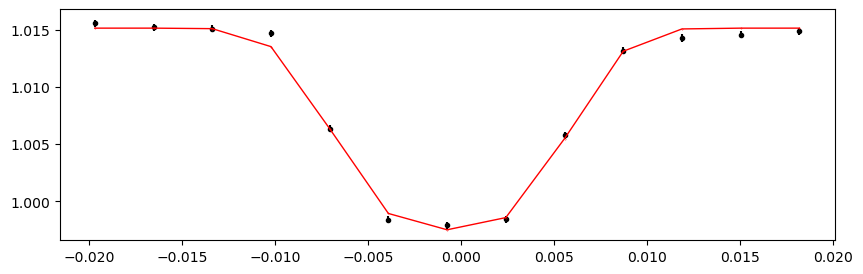

55261.524426694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.15it/s]


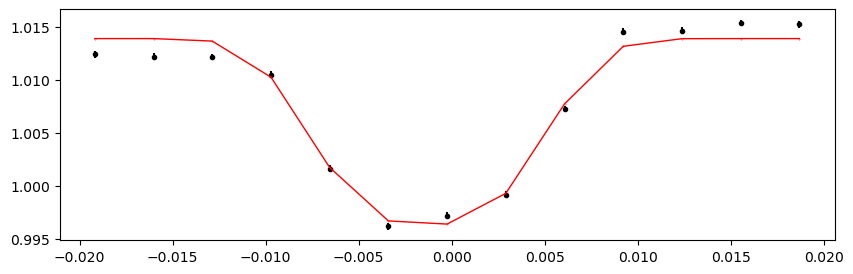

55267.998606694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.91it/s]


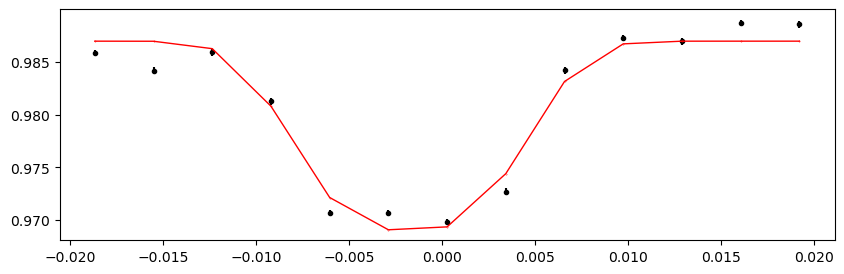

55280.946966694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.25it/s]


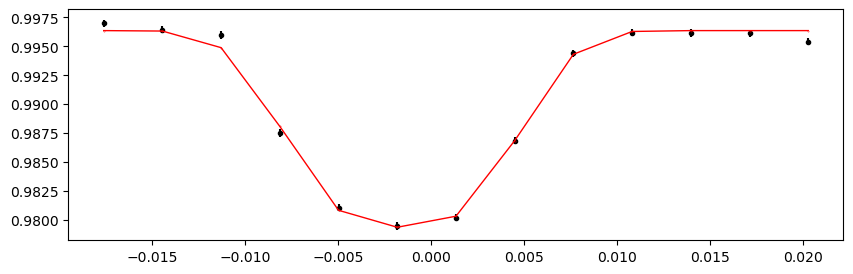

55287.421146693996 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.05it/s]


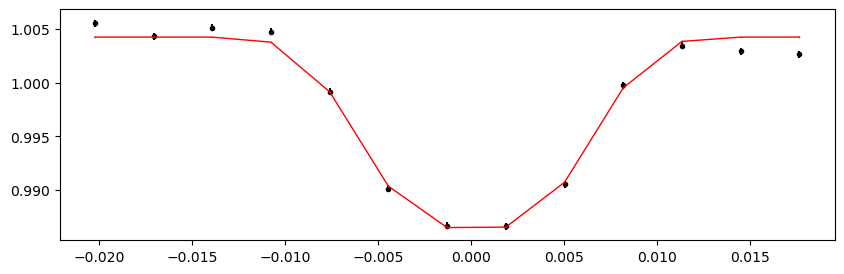

55293.895326694 1.0003898377968548 -0.017223173189843427 -0.32095517717339916


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.16it/s]


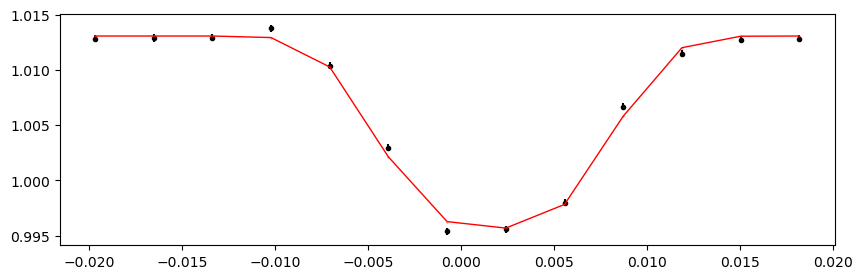

In [43]:
%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

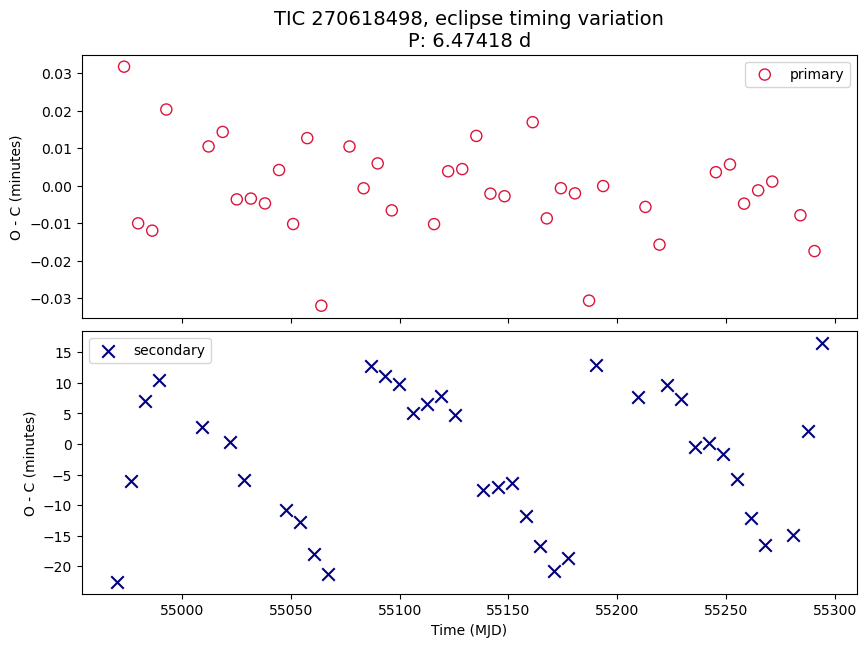

In [46]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 1600]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 1600]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


#
# Second chunk
#

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 1600]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 1600]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

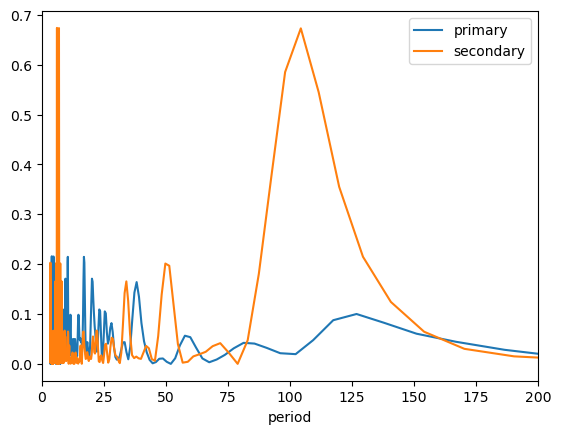

In [54]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 200)
plt.show()


## Results Summary

In [50]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ works for secondary, but not primary"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,270618498
has_etv,Practice
comments,"Reproducing Kepler ETV in 2013ApJ works for secondary, but not primary"
period,6.47418
depth_pct_p,20.11
depth_pct_s,1.72
epoch_p,54966.895501
epoch_s,54970.186327
num_sectors,17
time_span,335.97



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
270618498,Practice,"Reproducing Kepler ETV in 2013ApJ works for secondary, but not primary",6.47418,20.11,1.72,54966.895501,54970.186326694,17,335.97,54964.01,55299.98

